Imports.

In [23]:
import numpy as np

import pandas as pd

from ast import literal_eval

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

Load `chaps_df` and undo array-to-list.

In [2]:
chaps_df = pd.read_csv('../data/animorphs_chaps.csv')

for col in ['clean','clean_no_stops', 'vec_clean']:
    chaps_df[col] = chaps_df[col].map(literal_eval) # as lists
    
for col in ['vec_clean']:
    chaps_df[col] = chaps_df[col].map(np.array) # as array
    
chaps_df.head()

,book,chapter,text,authenticity,clean,clean_no_stops,vec_clean
0,1,1,"My name is Jake. That's my first name, obvious...",1,"[name, thats, first, name, obviously, cant, te...","[my, name, is, jake, thats, my, first, name, o...","[0.050813198, 0.21546867, -0.11217794, 0.05301..."
1,1,2,"""A flying saucer?"" Marco said. He did laugh. T...",1,"[flying, saucer, laugh, looked, could, feel, h...","[a, flying, saucer, marco, said, he, did, laug...","[0.0059409393, 0.23846294, -0.09167185, 0.0067..."
2,1,3,<They have come to destroy you.>\nIt was stran...,1,"[come, destroy, strange, way, knew, telling, t...","[they, have, come, to, destroy, you, it, was, ...","[0.00516426, 0.25513598, -0.040639274, -0.0519..."
3,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...,1,"[yeerks, twin, red, lights, slowed, turned, ci...","[yeerks, the, twin, red, lights, slowed, they,...","[-0.027513022, 0.24088845, 0.00715725, -0.0299..."
4,1,5,"The Hork-Bajir pointed his gun, or whatever it...",1,"[hork, bajir, pointed, gun, whatever, around, ...","[the, hork, bajir, pointed, his, gun, or, what...","[-0.037028935, 0.29484826, 0.030976577, -0.076..."


Load `books_df` and undo array-to-list.

In [3]:
books_df = pd.read_csv('../data/animorphs_books.csv')

for col in ['book_vec','avg_chap_vec']:
    books_df[col] = books_df[col].map(literal_eval) # as lists
    
for col in ['book_vec','avg_chap_vec']:
    books_df[col] = books_df[col].map(np.array) # as array
    
books_df.head()

,book,book_vec,avg_chap_vec,authenticity
0,1,"[0.0010895184, 0.2081184, -0.05931624, 0.01286...","[-0.0027950632, 0.20982857, -0.058019806, 0.01...",1
1,2,"[-0.00226549, 0.22271992, -0.065148115, 0.0113...","[-0.0009056398, 0.22276656, -0.06607905, 0.012...",1
2,3,"[-0.0129256295, 0.21558568, -0.05230921, 0.003...","[-0.015145328, 0.21650073, -0.0493573, 0.00182...",1
3,4,"[-0.0025382496, 0.21817772, -0.069260634, 0.00...","[-0.0047836, 0.21768926, -0.06756582, 0.005677...",1
4,5,"[-0.00024276103, 0.22412194, -0.05454963, 0.00...","[-0.0009346308, 0.22463025, -0.055034954, 0.00...",1


Modeling.

In [25]:
seed = 1007
cv_times = 5

A manual, not-cross-validated gridsearch. This is desirable because of our leave-one-out training, which will be detailed ahead.

In [5]:
def do_gs(model, params, X, y): # do gridsearch
    # adapted from David at https://stackoverflow.com/questions/34624978
    
    best_score = -1
    best_p = {}
    
    for p in ParameterGrid(params):
        
        model.set_params(**p)
#         print(p)
        model.fit(X,y)
        
        if model.score(X,y) > best_score:
            best_score = model.score(X,y)
            best_p = p
            
    model.set_params(**best_p)
    model.fit(X,y)
    
    return model

Generate results using leave-one-out training—each book's results are generated by a model trained on all other books. We have two different functions to get these results: one operates on books as wholes, the other averages chapters of specific books.

In [36]:
def pred_one_out_b(book_out, model, params, books_df=books_df):

    train_inds = books_df['book'] != book_out
    test_inds = books_df['book'] == book_out
    
    X_b = pd.DataFrame(list(books_df['book_vec'])).loc[train_inds]
    y_b = books_df['authenticity'].loc[train_inds]
    
    X_b_test = pd.DataFrame(list(books_df['book_vec'])).loc[test_inds]

    model = do_gs(model, params, X_b, y_b)
#     print(model.get_params())
    return (model.predict_proba(X_b_test)[:,1][0])

In [51]:
def pred_one_out_c(book_out, model, params, chaps_df=chaps_df):

    train_inds = chaps_df['book'] != book_out
    test_inds = chaps_df['book'] == book_out
    
    X_c = pd.DataFrame(list(chaps_df['vec_clean'])).loc[train_inds]
    y_c = chaps_df['authenticity'].loc[train_inds]
    
    X_c_test = pd.DataFrame(list(chaps_df['vec_clean'])).loc[test_inds]

    model = do_gs(model, params, X_c, y_c)
    print(model.get_params())
    return (np.mean(model.predict(X_c_test)), 
            np.mean(model.predict_proba(X_c_test)[:,1]))

In [68]:
svm_params = {
    'C':np.logspace(-3,3,7),
    'kernel':['rbf']
}
svm = SVC(random_state=seed, gamma='scale',
          max_iter=1e4, probability=True)

In [9]:
results = pd.DataFrame({'book':range(1,55)})
results['book pred proba'] = results['book'].map(
    lambda b:pred_one_out_b(b, svm, svm_params))
temp_c = results['book'].map(lambda b:pred_one_out_c(b, svm, svm_params))
results['chap pred avg'] = temp_c.map(lambda p:p[0])
results['chap pred proba avg'] = temp_c.map(lambda p:p[1])

In [10]:
results['authenticity'] = books_df['authenticity']

In [11]:
results.to_csv('../data/results_svm.csv', index=False)

In [12]:
def col_acc(col):
    return 1 - np.mean(
        (results['authenticity']-results[col].map(np.round)
        ).map(lambda a:abs(int(a)))
    )

In [13]:
col_acc('chap pred avg'), col_acc('chap pred proba avg'), \
    col_acc('book pred proba')

(0.9074074074074074, 0.8888888888888888, 0.8888888888888888)

In [74]:
def inacc_set(thing, results=results):
    return set(results[np.round(thing) != results['authenticity']].index)

bads = sorted(list(inacc_set(results['book pred proba']) |
                   inacc_set(results['chap pred proba avg']) |
                   inacc_set(results['chap pred avg'])))
bads

[13, 16, 24, 25, 28, 33, 52, 53]

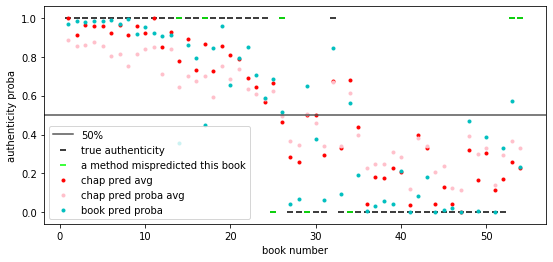

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
plt.axhline(.5,c='#555555')
plt.scatter(range(1,55),results['authenticity'],
            c='k', marker='_')
plt.scatter([b+1 for b in bads], results.loc[bads, 'authenticity'],
            c='lime', marker='_', alpha=1)
plt.scatter(range(1,55),results['chap pred avg'],
            c='r', marker='.')
plt.scatter(range(1,55),results['chap pred proba avg'],
            c='pink', marker='.')
plt.scatter(range(1,55),results['book pred proba'], 
            c='c', marker='.')
plt.legend(['50%','true authenticity', 'a method mispredicted this book',
            'chap pred avg','chap pred proba avg','book pred proba'])
plt.xlabel('book number')
plt.ylabel('authenticity proba')
plt.savefig('../figures/svm_results.png');

This is strong evidence **against** this method of inquiry with regard to these texts. The above plot shows that most authentic Animorphs books are early on in the series, and most ghostwritten books are later. Because the themes and topics of the series changed over time, I suspect that our models are better at recognizing content differences than author differences—the books that they fail to accurately predict are those unusually placed, chronologically. This is strong evidence that this method does not suit this problem.

After reading [these](https://pdfs.semanticscholar.org/3fd9/c3a45629393465e7258dee0f1eaab32ea4bc.pdf) [papers](https://www.aclweb.org/anthology/Q15-1016.pdf), I have become skeptical of the ability of conceptual vectorizations such as word2vec in determining true authorship, especially when the corpus influences it to respond more to author-agnostic content than to style.

Because Word2Vec analysis seems unfruitful, I will treat this as my baseline and attempt some more traditional stylometric analyses that are clearly geared toward style rather than content.